In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from src.util import read_video_frames, display_image, draw_bounding_box, draw_3d_bounding_boxes, render_scene, get_character_placeholder
from src.operations2d import get_2d_bounding_boxes, bounding_boxes_to_image_chunks
from src.operations3d import get_3d_bounding_boxes, adjust_rotation_by_chunk_rotation, get_box_meshes

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


final text_encoder_type: bert-base-uncased


[02/04 16:03:20 detectron2]: Rank of current process: 0. World size: 1
[02/04 16:03:20 detectron2]: Environment info:
-------------------------------  -------------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.8.20 (default, Oct  3 2024, 15:24:27) [GCC 11.2.0]
numpy                            1.24.4
detectron2                       0.6 @/home/max/miniconda3/envs/instruct360/lib/python3.8/site-packages/detectron2
Compiler                         GCC 13.3
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.4.1+cu121 @/home/max/miniconda3/envs/instruct360/lib/python3.8/site-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    No: torch.cuda.is_available() == False
Pillow                           10.4.0
torchvision                      0.19

Using cache found in /home/max/.cache/torch/hub/facebookresearch_dinov2_main


final text_encoder_type: bert-base-uncased
[02/04 16:03:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from checkpoints/ovmono3d_lift.pth ...
[02/04 16:03:23 fvcore.common.checkpoint]: [Checkpointer] Loading from checkpoints/ovmono3d_lift.pth ...
WARNING [02/04 16:03:23 fvcore.common.checkpoint]: Some model parameters or buffers are not found in the checkpoint:
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.attn.proj.{bias, weight}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.attn.qkv.{bias, weight}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.attn.{relative_position_bias_table, relative_position_index}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.mlp.fc1.{bias, weight}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.mlp.fc2.{bias, weight}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.norm1.{bias, weight}
roi_heads.groundingdino_model.backbone.0.layers.0.blocks.0.norm2.{bias, weight}


In [5]:
video_path = "vids/office.mp4"
frame_index = 10

object_class = "cupboard"

Read out a single frame of the input video

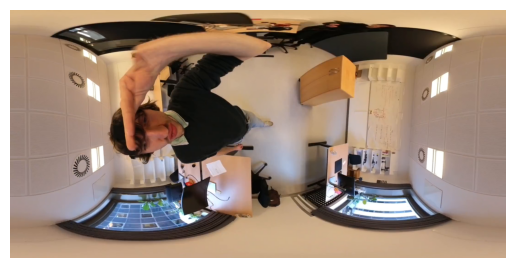

In [6]:
input_frame = read_video_frames(video_path)[frame_index]

display_image(input_frame)

Get 2d bounding boxes for objects of interest

In [7]:
bounding_boxes = get_2d_bounding_boxes(input_frame, object_class)
print(bounding_boxes)

[[0.64107305 0.2866996  0.11808857 0.20792973]]


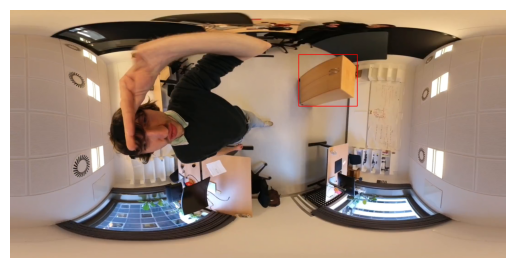

In [8]:
frame_with_boxes = input_frame.copy()
for box in bounding_boxes:
    frame_with_boxes = draw_bounding_box(frame_with_boxes, box)

display_image(frame_with_boxes)

Extract and undistort image chunks around objects

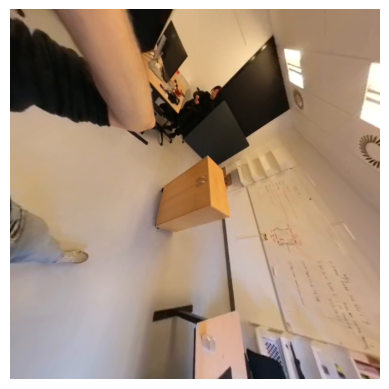

In [9]:
image_chunks = bounding_boxes_to_image_chunks(input_frame, bounding_boxes)
display_image(image_chunks[0].image)

Get 3d bounding boxes

In [31]:
bb_centers, bb_dimensions, bb_poses = get_3d_bounding_boxes(image_chunks[0], object_class)

/home/max/miniconda3/envs/instruct360/lib/python3.8/site-packages/transformers/modeling_utils.py:1161: FutureWarning:

The `device` argument is deprecated and will be removed in v5 of Transformers.

/home/max/miniconda3/envs/instruct360/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning:

torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.

/home/max/miniconda3/envs/instruct360/lib/python3.8/site-packages/torch/utils/checkpoint.py:92: UserWarning:

None of the inputs have requires_grad=True. Gradients will be None

/home/max/Documents/RA/instruct360/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning:

`torch.cuda.amp.autocast(args..

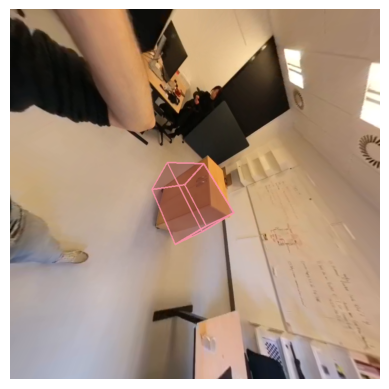

In [32]:
image_with_3d_boxes = draw_3d_bounding_boxes(image_chunks[0], bb_centers, bb_dimensions, bb_poses)
display_image(image_with_3d_boxes)

Get bounding box meshes in world space an render them

In [33]:
import open3d as o3d
bb_centers_adjusted, bb_poses_adjusted = adjust_rotation_by_chunk_rotation(bb_centers, bb_poses, image_chunks[0])
bb_meshes = get_box_meshes((bb_centers_adjusted, bb_dimensions, bb_poses_adjusted))
character_placeholder = get_character_placeholder()

coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])

render_scene(bb_meshes + [character_placeholder, coordinate_frame])